In [16]:
# 1. Import thư viện cần thiết
from google.colab import drive
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN

In [17]:
# 2. Đọc file csv và gắn index với giá Close
df = pd.read_csv('DOGE-USD.csv')
df1=df.reset_index()['Close']

In [18]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [19]:
# 4. Chia train test 
train_size = int(0.6 * len(df1))
test_size = int(0.3 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [20]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [21]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [22]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)

In [23]:
# 8. Define LSTM Model

model = Sequential()
model.add(SimpleRNN(50, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [24]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
13/13 [==============================] - 1s 43ms/step - loss: 0.0402 - val_loss: 0.0797
Epoch 2/100
13/13 [==============================] - 0s 24ms/step - loss: 0.0067 - val_loss: 0.0075
Epoch 3/100
13/13 [==============================] - 0s 23ms/step - loss: 0.0041 - val_loss: 0.0057
Epoch 4/100
13/13 [==============================] - 0s 26ms/step - loss: 0.0036 - val_loss: 0.0030
Epoch 5/100
13/13 [==============================] - 0s 25ms/step - loss: 0.0032 - val_loss: 0.0033
Epoch 6/100
13/13 [==============================] - 0s 16ms/step - loss: 0.0029 - val_loss: 0.0034
Epoch 7/100
13/13 [==============================] - 0s 15ms/step - loss: 0.0028 - val_loss: 0.0052
Epoch 8/100
13/13 [==============================] - 0s 15ms/step - loss: 0.0024 - val_loss: 0.0037
Epoch 9/100
13/13 [==============================] - 0s 15ms/step - loss: 0.0022 - val_loss: 0.0067
Epoch 10/100
13/13 [==============================] - 0s 16ms/step - loss: 0.0020 - val_loss: 0.0078

In [25]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)
y_pred_val=model.predict(X_val)

2/2 [==============================] - 0s 7ms/step


In [26]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)
y_pred_val=scaler.inverse_transform(y_pred_val)

In [27]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
valid_rmse = np.sqrt(np.mean((y_pred_val - yval)**2))
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)

Validation RMSE: 0.02149431598912933
Testing RMSE: 0.10063323622036928


In [28]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_percentage_error
r_squared = r2_score(ytest, y_pred)
print("Test_R-squared: ", r_squared) 
r_squared = r2_score(yval, y_pred_val)
print("Val_R-squared: ", r_squared) 

test_mape = mean_absolute_percentage_error(ytest, y_pred)
print("Testing MAPE",test_mape)
val_mape = mean_absolute_percentage_error(yval, y_pred_val)
print("Validation MAPE",val_mape)

Test_R-squared:  0.5299797644771943
Val_R-squared:  -2.007638166288975
Testing MAPE 0.29406256165854133
Validation MAPE 0.13842279245411865


In [29]:
# 13. Dự báo 30 ngày tiếp theo
x_input=val_data[60:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=96
i=0
while(i<30):
    
    if(len(temp_input)>96):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1


[0.04015102]
97
1 day input [0.10565394 0.10076108 0.10172853 0.09786751 0.10063375 0.10053276
 0.10233154 0.10088841 0.10494116 0.10247204 0.10381857 0.10345559
 0.10547392 0.10866899 0.11151572 0.11213629 0.11525818 0.12133511
 0.12555764 0.12381301 0.12016129 0.11920409 0.11511914 0.11726919
 0.12421111 0.12181371 0.12699344 0.12743399 0.12062087 0.12449066
 0.1241672  0.12526491 0.12623822 0.12981676 0.12704174 0.13850184
 0.13558047 0.13090861 0.13384755 0.13793835 0.13254201 0.12881564
 0.133246   0.12970406 0.11700574 0.11643493 0.11831128 0.11797758
 0.11799514 0.120012   0.12843803 0.12222206 0.12620602 0.12790527
 0.12503513 0.12685294 0.12276213 0.12293923 0.12112142 0.11615684
 0.11598999 0.11806247 0.11682132 0.11593584 0.11771413 0.11560067
 0.11012236 0.10687167 0.10722147 0.10723611 0.10612815 0.10185733
 0.09432996 0.09410456 0.09521837 0.10166852 0.10465429 0.10720977
 0.10000732 0.10418155 0.10973011 0.10466747 0.10724782 0.10237984
 0.1102936  0.10605644 0.11105175 

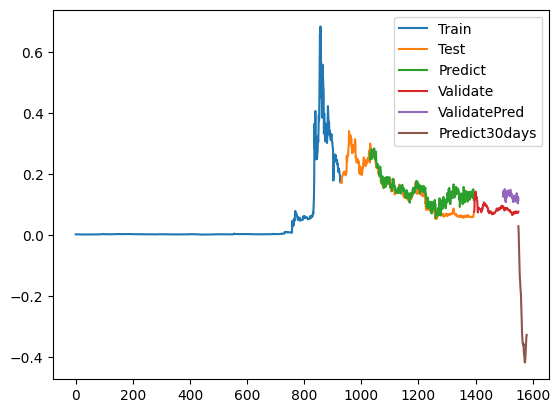

In [30]:
# 14.Vẽ hình

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))
val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predict','Validate','ValidatePred','Predict30days'])
plt.show()